<a href="https://colab.research.google.com/github/Mateusz-best-creator/Learning_PyTorch/blob/main/PyTorch_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning With PyTorch

## Download Helper Scripts

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/Mateusz-best-creator/Learning_PyTorch.git
    !mv Learning_PyTorch/going_modular/scripts .
    !rm -rf Learning_PyTorch
    from scripts import data_setup, engine

2.3.1+cu121
0.18.1+cu121
[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'Learning_PyTorch'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 34 (delta 9), reused 3 (delta 1), pack-reused 0
Receiving objects: 100% (34/34), 5.17 MiB | 5.20 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {device}")

Device = cuda


## Get Data

In [3]:
import requests
from pathlib import Path
import zipfile

def download_data(url, data_path):
  if data_path.is_dir():
      print("Data is already downloaded")
  else:
      data_path.mkdir(parents=True, exist_ok=True)
      try:
        print(f"Downloading data from {url}")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        zip_file_path = data_path / "data.zip"
        with open(zip_file_path, "wb") as f:
            f.write(response.content)
        if url.endswith(".zip"):
          print(f"Unzipping file...")
          with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
              zip_ref.extractall(data_path)
          zip_file_path.unlink()  # Remove the zip file after extraction
      except Exception as e:
          print(f"Error: {e}")

url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"
download_data(url, Path("data/pizza_steak_sushi"))

Unzipping file...


In [4]:
train_dir = Path("data/pizza_steak_sushi/train")
test_dir = Path("data/pizza_steak_sushi/test")
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [5]:
import os
# Walk through our data directory
for root, dirs, images in os.walk("data/pizza_steak_sushi"):
  print(f"We have {len(dirs)} directories | {len(images)} files in {root}")

We have 2 directories | 0 files in data/pizza_steak_sushi
We have 3 directories | 0 files in data/pizza_steak_sushi/test
We have 0 directories | 58 files in data/pizza_steak_sushi/test/steak
We have 0 directories | 46 files in data/pizza_steak_sushi/test/pizza
We have 0 directories | 46 files in data/pizza_steak_sushi/test/sushi
We have 3 directories | 0 files in data/pizza_steak_sushi/train
We have 0 directories | 146 files in data/pizza_steak_sushi/train/steak
We have 0 directories | 154 files in data/pizza_steak_sushi/train/pizza
We have 0 directories | 150 files in data/pizza_steak_sushi/train/sushi


## Create Datasets and DataLoaders

**IMPORTANT**: when using pretrained model it is important that the data is properly transformed. There are 2 ways to fulfill this condition:

1. Manually create appropriate transformations.
2. Use automatic transformations for given model.

### Manual Transforms

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([transforms.Resize(size=(224, 224)),
                                        transforms.ToTensor(),
                                        normalize])

In [7]:
from scripts.data_setup import create_dataloaders

BATCH_SIZE = 32
train_dataloader, test_dataloader, CLASS_NAMES = create_dataloaders(train_dir,
                                                                     test_dir,
                                                                     manual_transforms,
                                                                     manual_transforms,
                                                                     BATCH_SIZE)
train_dataloader, test_dataloader, CLASS_NAMES

(<torch.utils.data.dataloader.DataLoader at 0x782fe2303a30>,
 ['pizza', 'steak', 'sushi'])

### Automatic Transforms

In [8]:
from torchvision.models import efficientnet_b0

# Get pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_dataloader, test_dataloader, CLASS_NAMES = create_dataloaders(train_dir,
                                                                     test_dir,
                                                                     auto_transforms,
                                                                     auto_transforms,
                                                                     BATCH_SIZE)
train_dataloader, test_dataloader, CLASS_NAMES

(<torch.utils.data.dataloader.DataLoader at 0x782fe2303070>,
 ['pizza', 'steak', 'sushi'])

## Getting a pretrained model

### Setting up pretrained model

In [10]:
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.features[:2], model.avgpool, model.classifier

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 24.6MB/s]


(Sequential(
   (0): Conv2dNormActivation(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): SiLU(inplace=True)
   )
   (1): Sequential(
     (0): MBConv(
       (block): Sequential(
         (0): Conv2dNormActivation(
           (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
           (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): SiLU(inplace=True)
         )
         (1): SqueezeExcitation(
           (avgpool): AdaptiveAvgPool2d(output_size=1)
           (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
           (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
           (activation): SiLU(inplace=True)
           (scale_activation): Sigmoid()
         )
         (2): Conv2dNormActivation(
           (0): Conv2d(32, 16, kernel_size=

In [11]:
from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

### Freezing the base model and changing output layer

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [13]:
# Freeze all of the layers in features section (non trainable)
for param in model.features.parameters():
    param.requires_grad = False

# Update classifier head
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                 nn.Linear(in_features=1280, out_features=len(CLASS_NAMES), bias=True))

summary(model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size",
                  "output_size",
                  "num_params",
                  "trainable",])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

## Train Model

In [14]:
from scripts import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

EPOCHS=10
model_results = engine.train(model,
                             train_dataloader,
                             test_dataloader,
                             optimizer,
                             loss_fn,
                             EPOCHS,
                             device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9565 | train_acc: 0.5583 | test_loss: 0.6774 | test_acc: 0.9006
Epoch: 2 | train_loss: 0.6922 | train_acc: 0.8354 | test_loss: 0.5484 | test_acc: 0.8943
Epoch: 3 | train_loss: 0.5489 | train_acc: 0.8688 | test_loss: 0.4678 | test_acc: 0.9034
Epoch: 4 | train_loss: 0.4652 | train_acc: 0.9000 | test_loss: 0.4225 | test_acc: 0.9131
Epoch: 5 | train_loss: 0.4644 | train_acc: 0.8625 | test_loss: 0.3705 | test_acc: 0.9159
Epoch: 6 | train_loss: 0.4084 | train_acc: 0.8625 | test_loss: 0.3592 | test_acc: 0.8972
Epoch: 7 | train_loss: 0.4132 | train_acc: 0.8458 | test_loss: 0.3566 | test_acc: 0.9131
Epoch: 8 | train_loss: 0.3697 | train_acc: 0.9167 | test_loss: 0.3169 | test_acc: 0.9250
Epoch: 9 | train_loss: 0.3712 | train_acc: 0.8771 | test_loss: 0.3124 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.2957 | train_acc: 0.9250 | test_loss: 0.3128 | test_acc: 0.8909


In [15]:
model_results

{'train_loss': [0.9564856886863708,
  0.6922356446584066,
  0.5488726814587911,
  0.4651673952738444,
  0.4644183337688446,
  0.40836482842763266,
  0.413173653682073,
  0.36971188286940254,
  0.3711959441502889,
  0.2957330673933029],
 'train_acc': [0.5583333333333333,
  0.8354166666666667,
  0.86875,
  0.9,
  0.8625,
  0.8625,
  0.8458333333333333,
  0.9166666666666666,
  0.8770833333333333,
  0.925],
 'test_loss': [0.6774267792701721,
  0.5484198868274689,
  0.46780362725257874,
  0.42248205542564393,
  0.3705077350139618,
  0.35922500491142273,
  0.3565573424100876,
  0.3169012129306793,
  0.3124442011117935,
  0.312751442193985],
 'test_acc': [0.9005681818181819,
  0.8943181818181818,
  0.903409090909091,
  0.9130681818181818,
  0.915909090909091,
  0.897159090909091,
  0.9130681818181818,
  0.925,
  0.9130681818181818,
  0.890909090909091]}

## Save the model

In [16]:
from scripts import utils

utils.save_model(model,
                 Path("models"),
                 "model_0_efficient_net_b0.pth")

[INFO] Saving model to: models/model_0_efficient_net_b0.pth


## Visualizing loss curves

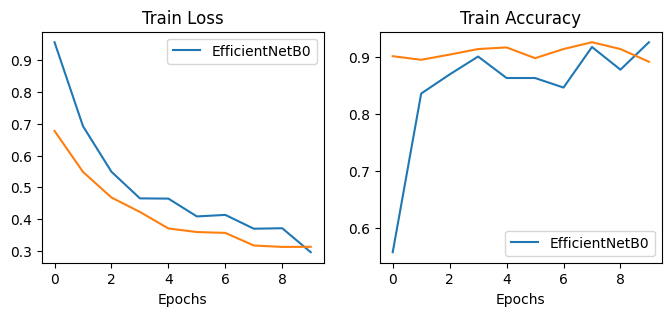

In [17]:
import numpy as np
def plot_loss_curves(epochs, results_dictionary, label):
  # Setup a plot
  plt.figure(figsize=(8, 3))
  epochs = np.arange(epochs)
  # Plot train loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, results_dictionary["train_loss"], label=label)
  plt.plot(epochs, results_dictionary["test_loss"])
  plt.title("Train Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot train accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, results_dictionary["train_acc"], label=label)
  plt.plot(epochs, results_dictionary["test_acc"])
  plt.title("Train Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()

plot_loss_curves(EPOCHS, model_results, "EfficientNetB0")

## Predictions on images from the test set

In [18]:
from PIL import Image

def pred_and_plot_image(model,
                        image_path,
                        true_label,
                        transformations,
                        class_names=CLASS_NAMES,
                        device=device):
  original_image = Image.open(image_path)
  image = transformations(original_image).to(device)

  model.eval()
  with torch.inference_mode():
    logits = model(image.unsqueeze(dim=0))
    preds = torch.nn.functional.softmax(logits, dim=1)
    predicted_class = CLASS_NAMES[preds.argmax()]

  plt.imshow(image.permute(1,2,0).to("cpu"))
  probability = round(preds.max().item(), 3) * 100
  color = "#FF0000" if true_label != predicted_class else "#00FF00"
  plt.title('Predicted : {} | Actual :  {} | Probability : {}%'.format(predicted_class, true_label, probability), color=color)
  plt.axis("off")
  plt.show()

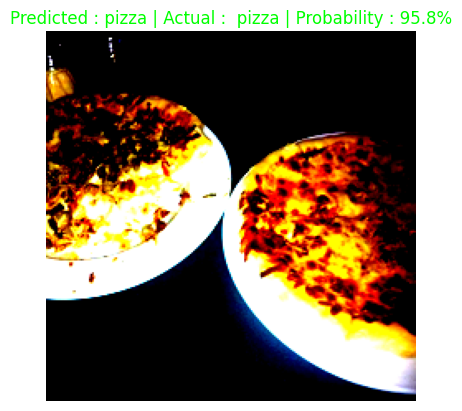

In [20]:
# Our own custom image
pred_and_plot_image(model,
                    "/content/data/pizza_steak_sushi/train/pizza/1008844.jpg",
                    "pizza",
                    weights.transforms())

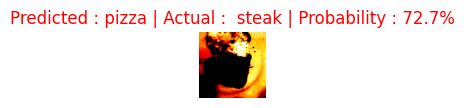

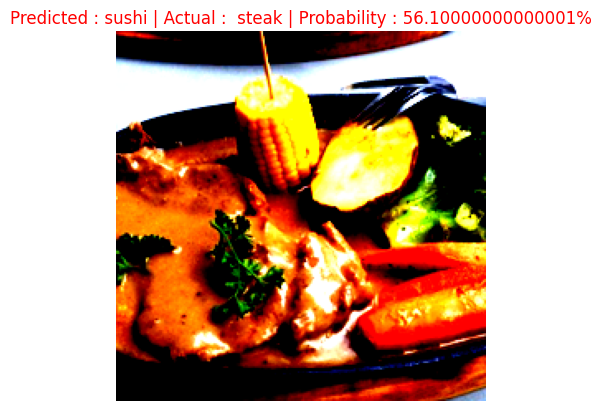

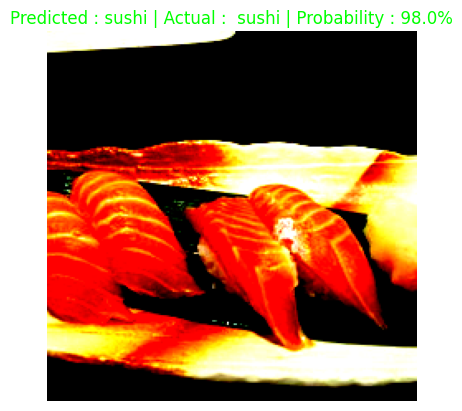

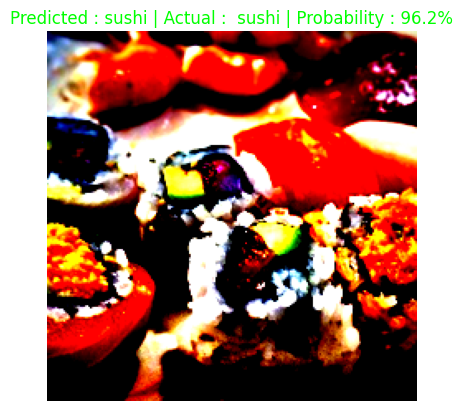

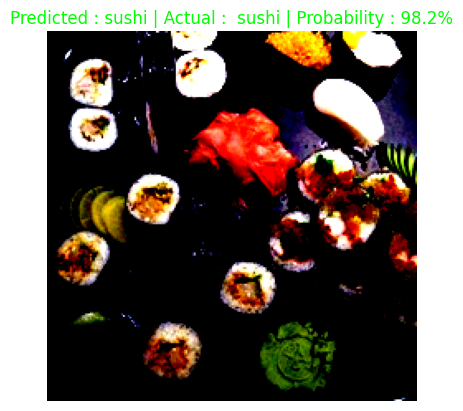

In [21]:
# Images from the test set
import random

test_paths = list(test_dir.glob("*/*.jpg"))
fig = plt.figure(figsize=(10, 5))
for index, path in enumerate(random.sample(test_paths, 5)):
  fig.add_subplot(5, 1, index+1)
  label = path.parts[-2]
  pred_and_plot_image(model,
                      path,
                      label,
                      weights.transforms())

## Confusion Matrix

In [39]:
try:
  from torchmetrics import ConfusionMatrix
except:
  !pip install torchmetrics
  from torchmetrics import ConfusionMatrix

final_preds = []
target = []
with torch.inference_mode():
  model.to("cpu")
  for img, label in test_dataloader:
    preds = torch.nn.functional.softmax(model(img), dim=1).argmax(dim=1).squeeze()
    for i, pred in enumerate(preds):
      final_preds.append(pred.item())
      target.append(label[i].item())

In [40]:
print(final_preds[:10]), target[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(None, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
confmat = ConfusionMatrix(task="multiclass", num_classes=3)
confusion_matrix = confmat(torch.tensor(final_preds), torch.tensor(target))

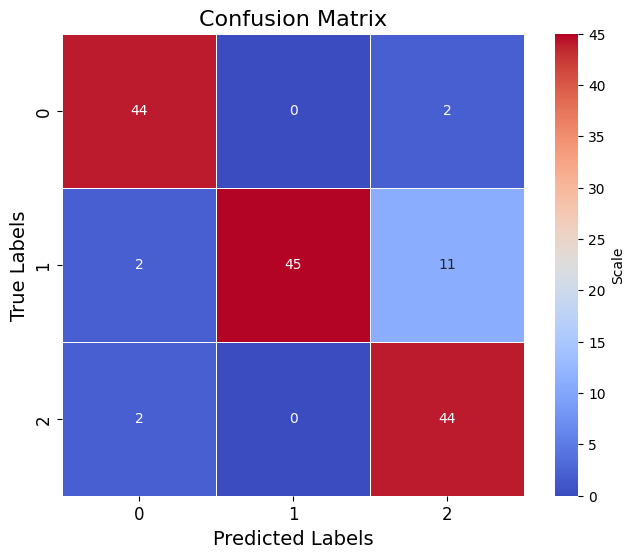

In [44]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix,
            annot=True,
            fmt='d',
            cmap='coolwarm',  # Choose a color palette
            cbar_kws={'label': 'Scale'},  # Label the color bar
            linewidths=0.5,  # Add lines between squares for better readability
            square=True)  # Ensure the heatmap is square
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()